In [1]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch

import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part53_othellogpt"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

extract_dir = '/root/ARENA_3.0/chapter1_transformer_interp/exercises/extracted_files'
sys.path.append(extract_dir)
sys.path.append("/root/miniconda3/envs/arena-env/lib/python3.11/site-packages")
from huggingface_hub import hf_hub_download
import chess_utils
#from plotly_utils import imshow
#from neel_plotly import scatter, line

MAIN = __name__ == "__main__"

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)


/opt/conda/envs/chessgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# # Download the zip file (replace 'model_name' and 'filename')
# repo_id = "adamkarvonen/chess_saes"  # e.g. "username/repo_name"
# filename = "chess-trained_model-layer_5-2024-05-23.zip"

# # This will download the zip file into the current directory
# zip_path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir="/root/chessgpt_sae")
# print(f"Downloaded file: {zip_path}")


In [3]:

# Path to the model file (adjust the file name as needed)
autoencoder_group_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/")
autoencoder_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/trainer4/ae.pt")

# Load the model weights (assuming the model definition is available)
autoencoder = torch.load(autoencoder_path)



In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model = AutoModelForCausalLM.from_pretrained("adamkarvonen/8LayerChessGPT2")
model.to(device)

# Dictionary to store activations
activations = []




/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:

    
sae = AutoEncoder.from_pretrained(Path(autoencoder_path), device=device)

In [6]:
import pandas as pd
import torch.nn.functional as F
import gc

model_activations = []
# Hook function to capture activations
def get_activation(name):
    def hook(model, input, output):
        model_activations.append(output.detach())
    return hook

# Register hooks on transformer layers (for example: transformer blocks 0 and 1)
# GPT-2 has multiple layers in the transformer. Here we hook into the first two layers as an example.
activation_handle=model.transformer.h[5].mlp.register_forward_hook(get_activation(f"mlp_block_{5}"))

encoded_activations = t.tensor([], device=device)
with open('data/lichess_100mb.csv', 'r') as f:
    data_df = pd.read_csv(f)
itos, stoi = meta['itos'], meta['stoi']
model.eval()

max_length = 500
for i in range(3):
    with t.inference_mode():
        gc.collect()
        t.cuda.empty_cache()
        tokenized_tensor = t.tensor([], device=device)
        for row in data_df.sample(n=3).transcript:
            tokenized = t.tensor([stoi[c] for c in row]).unsqueeze(0).to(device)
            if len(tokenized) < max_length:
                padded = F.pad(tokenized, (max_length - tokenized.shape[1], 0), mode='constant')
                tokenized_tensor = t.concat([tokenized_tensor, padded], dim=0)
            # Run the model (the hooks will capture activations automatically)
        output = model.generate(
            input_ids = tokenized_tensor.long(),
            temperature = 1.,
            max_new_tokens=1,
            do_sample=True,
            pad_token_id=0
        )
        model_activations_tensor = einops.rearrange(model_activations[0], "x y z -> (x y) z")
        # Inspect the captured activations

        encoded_activations = t.concat([encoded_activations, sae.encode(model_activations_tensor)], dim=0).max(dim=0).values.unsqueeze(0)

activation_handle.remove()

/tmp/ipykernel_98384/1136857341.py:18: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(f)


In [7]:
max_activations = encoded_activations.squeeze(dim=0)
max_activations.shape
del output
del tokenized_tensor
del encoded_activations
del model_activations_tensor
del model_activations
gc.collect()
t.cuda.empty_cache()


In [8]:
max_activations.shape

torch.Size([4096])

In [9]:
check_indices=t.tensor([156,  215,  390,  583,  670,  709,  727, 1155, 1327, 1536, 1596, 1730,
        1777, 1797, 1881, 1957, 2154, 2201, 2276, 2283, 2424, 2485, 2674, 2835,
        3003, 3037, 3109, 3368, 3649, 3737]).to(device)
max_check_activations=t.zeros_like(max_activations)
max_check_activations[check_indices]=max_activations[check_indices]
max_check_activations.shape


torch.Size([4096])

In [20]:
ctx_divisor = 1
def find_indices_between_moves(transcript):
    output = []
    for i in range(len(transcript)-1):
        if transcript[i] == " ":
            if transcript[i+1] == " ":
                return output
            if transcript[i-1] in ["+", "#"]:
                output.append(i-2)
            else:
                output.append(i-1)
    return output
def find_non_check_indices(transcript):
    output = []
    for i in range(len(transcript)-1):
        if transcript[i] == " ":
            if transcript[i+1] == " ":
                return output
            if transcript[i-1] not in ["+", "#"]:
                output.append(i-1)
    return output
def find_check_indices(transcript):
    output = []
    for i in range(len(transcript)-1):
        if transcript[i] == " ":
            if transcript[i+1] == " ":
                return output
            if transcript[i-1] == "+":
                output.append(i-2)
    return output
def gen_check_activation_hook(weight):
    def check_activation_hook(model, input, output):
        output_encoded=sae.encode(output)
        reconstruction_loss=output-sae.decode(output_encoded)
        output_encoded[..., check_indices] = max_activations[check_indices]*weight
        return sae.decode(output_encoded)+reconstruction_loss
    return check_activation_hook

def get_tokenized_transcript(transcript):
    if len(transcript) >= model.config.n_ctx/ctx_divisor:
        return transcript[:model.config.n_ctx//ctx_divisor], t.tensor([stoi[c] for c in transcript[:(model.config.n_ctx-1)//ctx_divisor]]).unsqueeze(0).to(device)
    tokenized = t.tensor([stoi[c] for c in transcript])
    pad_quantity = model.config.n_ctx//ctx_divisor - len(tokenized) - 1
    padded = F.pad(tokenized, (0, pad_quantity), mode='constant')
    
    return padded.unsqueeze(0).to(device)

def get_batch_of_tokenized_transcripts(transcripts):
    tokenized_transcripts = [get_tokenized_transcript(transcript) for transcript in transcripts]
    return t.stack(tokenized_transcripts, dim=0)

with t.inference_mode():
    baseline_check_probs=[]
    baseline_noncheck_probs=[]
    intervened_check_probs={}
    intervened_noncheck_probs={}
    batch_size = 20
    num_batches = 20
    for i in range(num_batches):
        batch = data_df.sample(n=batch_size).transcript
        tokenized_batch = get_batch_of_tokenized_transcripts(batch)
        base_output=model(tokenized_batch)
        # This would ideally be done more efficiently than cycling over each game in batch
        for i, game in enumerate(batch):
            indices_non_check = find_non_check_indices(game)
            indices_check = find_check_indices(game)
            
            if indices_check:
                check_logits= base_output.logits[i, :, indices_check, :]
                baseline_check_probs.append(F.softmax(check_logits, dim=-1))
            noncheck_logits= base_output.logits[i, :, indices_non_check, :]
            baseline_noncheck_probs.append(F.softmax(noncheck_logits, dim=-1))
        for weight in np.linspace(0.0, 1.0, num=8):
            check_activation_handle=model.transformer.h[5].mlp.register_forward_hook(gen_check_activation_hook(weight))
            intervened_check_probs[weight]=[]
            intervened_noncheck_probs[weight]=[]
            base_output=model(tokenized_batch)
            # This would ideally be done more efficiently than cycling over each game in batch
            for i, game in enumerate(batch):
                indices_non_check = find_non_check_indices(game)
                indices_check = find_check_indices(game)
                if indices_check:
                    check_logits= base_output.logits[i, :, indices_check, :]
                    intervened_check_probs[weight].append(F.softmax(check_logits, dim=-1))
                noncheck_logits= base_output.logits[i, :, indices_non_check, :]
                intervened_noncheck_probs[weight].append(F.softmax(noncheck_logits, dim=-1))
            check_activation_handle.remove()

baseline_check_probs = t.concat(baseline_check_probs, dim=1)
baseline_check_probs = einops.rearrange(baseline_check_probs, "x y z -> (x y) z")
baseline_noncheck_probs = t.concat(baseline_noncheck_probs, dim=1)
baseline_noncheck_probs = einops.rearrange(baseline_noncheck_probs, "x y z -> (x y) z")
intervened_check_probs = {weight: einops.rearrange(t.concat(logits, dim=1), "x y z -> (x y) z") for weight, logits in intervened_check_probs.items()}
intervened_noncheck_probs = {weight: einops.rearrange(t.concat(logits, dim=1), "x y z -> (x y) z") for weight, logits in intervened_noncheck_probs.items()}

In [19]:
[baseline_check_probs[x].shape for x in range(len(baseline_check_probs))]

[torch.Size([1, 13, 32]),
 torch.Size([1, 7, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 6, 32]),
 torch.Size([1, 7, 32]),
 torch.Size([1, 4, 32]),
 torch.Size([1, 8, 32]),
 torch.Size([1, 2, 32]),
 torch.Size([1, 7, 32]),
 torch.Size([1, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 10, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 9, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 8, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 32]),
 torch.Size([1, 18, 32]),
 torch.Size([1, 9, 32]),
 torch.Size([1, 2, 32]),
 torch.Size([1, 11, 32]),
 torch.Size([1, 8, 32]),
 torch.Size([1, 5, 32]),
 torch.Size([1, 7, 32]),
 torch.Size([1, 4, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 32]),
 torch.Size([1, 32]),
 torch.Size([1, 14, 32]),
 torch.Size([1, 7, 32]),
 torch.Size([1, 3, 32]),
 torch.Size([1, 5, 32]),
 torch.Size([1, 12, 32]),
 torch.Size([1, 5, 32]),
 torch.Size([1, 8, 32]),
 torch.Size([1, 32]),
 torch.Size(

In [22]:
meta.keys()


dict_keys(['vocab_size', 'itos', 'stoi'])

1

In [ ]:
with t.inference_mode():
    print(model(input_ids=tokenized_batch[0][0][200:]).logits[:, 6][-60:-30])

tensor([ 9.3274, 11.6264, -3.0657,  5.3683,  6.5171, -0.0984,  6.0806, 16.3682,
         5.3552,  8.7942,  7.3081, -1.7045,  2.8441,  7.3796,  2.7388,  4.7900,
        -5.0419,  5.8619,  5.7096,  7.8789,  3.5669,  8.6516,  6.6945,  8.4714,
         5.1962, -1.3700,  1.8894,  5.8380,  0.8895,  6.1783])


In [ ]:
tokenized_batch[0][0][pad_quantities[0]:]
pad_quantities[0]

688

In [21]:
# with t.inference_mode():
#     print(model(t.tensor([], device=device)))

avg_baseline_check_logits = baseline_check_probs.mean(dim=0)
avg_baseline_noncheck_logits = baseline_noncheck_probs.mean(dim=0)
weight=0.2
for weight, logits in intervened_check_probs.items():
    print(weight)
    out=logits.mean(dim=0)-avg_baseline_check_logits
    print(out[0], out[2])
for weight, logits in intervened_noncheck_probs.items():
    print(weight)
    out=logits.mean(dim=0)-avg_baseline_noncheck_logits
    print(out[0], out[2])

0.0
tensor(0.0057, device='cuda:0') tensor(-0.0037, device='cuda:0')
0.14285714285714285
tensor(0.0060, device='cuda:0') tensor(-0.0049, device='cuda:0')
0.2857142857142857
tensor(0.0065, device='cuda:0') tensor(-0.0062, device='cuda:0')
0.42857142857142855
tensor(0.0077, device='cuda:0') tensor(-0.0081, device='cuda:0')
0.5714285714285714
tensor(0.0110, device='cuda:0') tensor(-0.0121, device='cuda:0')
0.7142857142857142
tensor(0.0182, device='cuda:0') tensor(-0.0201, device='cuda:0')
0.8571428571428571
tensor(0.0292, device='cuda:0') tensor(-0.0321, device='cuda:0')
1.0
tensor(0.0392, device='cuda:0') tensor(-0.0428, device='cuda:0')
0.0
tensor(-0.0005, device='cuda:0') tensor(-6.2663e-05, device='cuda:0')
0.14285714285714285
tensor(-0.0008, device='cuda:0') tensor(-2.2409e-05, device='cuda:0')
0.2857142857142857
tensor(-0.0012, device='cuda:0') tensor(4.9610e-05, device='cuda:0')
0.42857142857142855
tensor(-0.0014, device='cuda:0') tensor(0.0002, device='cuda:0')
0.5714285714285714


In [ ]:
baseline_check_probs.mean(dim=0)


tensor([3.7796e-05, 8.0471e-06, 9.9995e-01, 1.1071e-08, 9.5053e-09, 4.8021e-09,
        2.5965e-08, 6.1452e-08, 8.3393e-08, 6.4022e-08, 8.7259e-08, 7.9774e-08,
        3.5692e-08, 2.7921e-08, 1.5617e-09, 8.2342e-10, 8.6016e-08, 1.1287e-07,
        1.5048e-08, 2.0725e-08, 8.6494e-09, 2.6951e-08, 8.2879e-08, 1.1988e-08,
        1.9269e-08, 9.3213e-09, 4.1028e-08, 4.9002e-08, 8.0009e-08, 3.0152e-08,
        1.1094e-08, 1.8218e-08])

In [ ]:
meta['itos'][6]


'1'

In [ ]:
# for row in data_df.transcript:
#     tokenized = t.tensor([stoi[c] for c in row]).unsqueeze(0).to(device)
    
#     # Run the model (the hooks will capture activations automatically)
    output = model.generate(
        input_ids = tokenized,
        temperature = 1.,
        max_new_tokens=7,
        do_sample=True,
        pad_token_id=0,
    )

#     # Inspect the captured activations
#     for name, activation in activations.items():
#         print(f"Activation from {name}: {activation.shape}")

#         hidden_size = activation.shape[1]
#         gpt2_activations_flat = activation.view(-1, hidden_size)

#         # Pass through the encoder
#         encoded = gated_sae.encode(gpt2_activations_flat)


#         print(f"Encoded activations shape: {encoded.shape}")
#         5/0

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Activation from mlp_block_5: torch.Size([1, 512])
Encoded activations shape: torch.Size([1, 4096])


ZeroDivisionError: division by zero

In [ ]:
data_df

,WhiteElo,BlackElo,Result,transcript
0,2339,2080,1-0,1.d4 e6 2.c4 Nf6 3.Nc3 Bb4 4.Bg5 h6 5.Bxf6 Qxf...
1,1406,1434,0-1,1.e4 e5 2.Nf3 f6 3.d4 a5 4.dxe5 fxe5 5.Bc4 Nc6...
2,1635,1654,1-0,1.d4 Nf6 2.Nf3 e6 3.Nbd2 d5 4.e3 Be7 5.Bd3 O-O...
3,1904,1983,0-1,1.e4 e5 2.Nf3 Nc6 3.Bb5 f5 4.d3 Nf6 5.O-O d6 6...
4,1806,1854,1/2-1/2,1.e4 c6 2.d4 d5 3.Nd2 dxe4 4.Nxe4 Nf6 5.Nxf6+ ...
...,...,...,...,...
291340,1711,1630,0-1,1.e4 e5 2.Nf3 d6 3.Bc4 c5 4.d3 Bg4 5.Be3 Nf6 6...
291341,1316,1413,1-0,1.c4 d5 2.cxd5 Qxd5 3.Nc3 Qd7 4.Nf3 e6 5.g3 Bb...
291342,2525,2541,0-1,1.Nf3 c6 2.g3 d5 3.Bg2 Nf6 4.O-O Bf5 5.d3 e6 6...
291343,1908,1854,0-1,1.d4 d5 2.c4 c6 3.g3 e6 4.Bg2 Nf6 5.Nf3 Be7 6....


In [ ]:
test_board = chess_utils.pgn_string_to_board(data_df.transcript.iloc[0][:7])
def tokenize_transcript(transcript):
    return t.tensor([stoi[c] for c in transcript]).unsqueeze(0).to(device)

def cut_game_transcript(transcript, step_size = 5):
    split = transcript.split(" ")
    output = []
    for length_to_cut in np.arange(5, len(split) - len(split) % 5, step_size):
        output.append(" ".join(split[:length_to_cut]))
    return output

def get_transcript_ending_in_check(transcript):
    split = transcript.split(" ")
    for i in range(len(split) - 1, -1, -1):
        if "+" in split[i]:
            return " ".join(split[:i+1])
    return ""

sub_data = data_df.sample(n=3000)
tokenized_games = []
has_feature = []
transcripts_list = []
feature = chess_utils.board_to_check_state
max_length = 512
for i, row in sub_data.iterrows():
    transcript = row.transcript
    sub_transcripts = cut_game_transcript(transcript)
    transcript_ending_in_check = get_transcript_ending_in_check(transcript)
    if transcript_ending_in_check != "":
        sub_transcripts += [transcript_ending_in_check]
    for sub_transcript in sub_transcripts:
        board = chess_utils.pgn_string_to_board(sub_transcript)
        transcripts_list.append(sub_transcript)
        has_feature.append(bool(feature(board).item()))
        tokenized = tokenize_transcript(sub_transcript).squeeze(0)
        tokenized_games.append(F.pad(tokenized, (max_length - tokenized.shape[0], 0), mode='constant'))
    
encoded = gated_sae.encode(t.stack(tokenized_games, dim=0))
has_feature = t.tensor(has_feature, device=device)




In [ ]:
next_token_predictions = dict()
for i, row in sub_data.iterrows():
    transcript = row.transcript
    transcript_ending_in_check = get_transcript_ending_in_check(transcript)
    if transcript_ending_in_check == "":
        continue
    assert transcript_ending_in_check[-1] == '+'
    tokenized = tokenize_transcript(transcript_ending_in_check[:-1])
    if len(tokenized[0]) >= model.config.n_ctx:
        continue
    output = model.generate(
        input_ids = tokenized,
        temperature = 1.,
        max_new_tokens=1,
        do_sample=True
    )
    next_token_predictions[i] = (output[0][-1].item())

# print(len(tokenize_transcript(input)[0]), len(output[0]))
# print(itos[output[0][-1].item()])





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
next_string_predictions = [itos[i] for i in next_token_predictions.values()]
next_string_predictions.count('+')/len(next_string_predictions)

0.9650606840750275

1.e4 c5 2.d4 cxd4 3.Qxd4 Nc6 4.Qd1 Nf6 5.Nc3 d6 6.Bg5 Bg4 7.Be2 Bxe2 8.Ngxe2 e6 9.O-O Be7 10.Nb5 a6 11.Bxf6 gxf6 12.Nbc3 Qc7 13.f3 Rg8 14.Kh1 Rc8 15.Ng3 b5 16.Qe2 b4 17.Na4 Qa5 18.b3 Nd4 19.Qd3 Nb5 20.Nb2 Qc7 21.Nc4 Nc3 22.a3 a5 23.axb4 axb4 24.Ra4 Nxa4 25.bxa4 Qxc4 26.Qxc4 Rxc4 27.Rc1 Kd7 28.h3 Rgc8 29.Ne2 Rxc2 30.Rxc2 Rxc2 31.Nd4 Rd2 32.Nb5 b3 33.a5 b2 34.Na3 d5 35.a6 Bc5 36.exd5 exd5 37.Kh2 Kc6 38.h4 Bxa3 39.a7 Bd6+ 40.Kh3 Kb7 41.a8=Q+ Kxa8 42.g3 b1=Q 43.Kg4 Qg1 44.f4 Qxg3+ 45.Kxg3 Rd3+ 46.Kg4 d4 47.Kf5 Re3 48.Kxf6 d3 49.Kxf7 d2 50.f5 d1=Q 51.f6 Qf1 52.Kg7 Rf3 53.Kxh7 Rxf6 54.h5 Qf5+ 55.Kg7 Rf7+ 56.Kg8 Qd7 57.Kh8 Rh7+
#


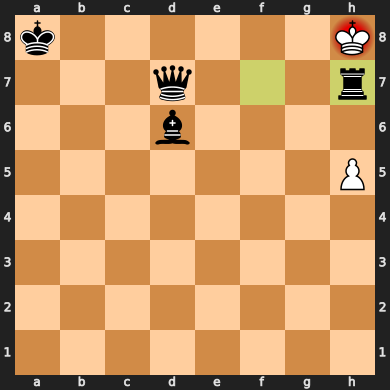

1.e4 e5 2.Nf3 Nf6 3.Nxe5 Nxe4 4.Qf3 Ng5 5.h4 Nxf3+ 6.Nxf3 Qe7+ 7.Be2 Qd6 8.d4 Nc6 9.c3 Qf6 10.Bg5 Qf5 11.Nbd2 Qc2 12.Rb1 h6 13.Bf4 d6 14.O-O Bg4 15.Ne1 Bxe2 16.Nxc2 Bxf1 17.Kxf1 O-O-O 18.Nc4 d5 19.Ne5 Bd6 20.Nxf7 Bxf4 21.Nxh8 Rxh8 22.Re1 g5 23.hxg5 Bxg5 24.Re6 Nd8 25.Re5 c6 26.Ne3 Bxe3 27.fxe3 b5 28.b4 a6 29.Kf2 h5 30.Kg3 h4+ 31.Kg4 Nf7 32.Re6 Kc7 33.Re7+ Kd6 34.Rxf7 c5 35.dxc5+ Ke5 36.Rf5+ Ke4 37.Rf3 Rh6 38.Kg5 h3 39.Kxh6 hxg2 40.Rg3 d4 41.cxd4 a5 42.bxa5 b4 43.c6 b3 44.Rxg2 Kxe3 45.c7 Kxd4 46.c8=Q b2 47.Rd2+ Ke3 48.Qc3+ Ke4 49.Qd3+ Ke5 50.Re2+
#


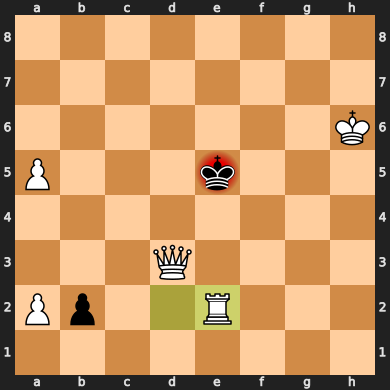

1.d4 d5 2.b3 e6 3.c4 dxc4 4.bxc4 Bb4+ 5.Bd2 Bxd2+ 6.Qxd2 Ne7 7.e4 O-O 8.f4 b6 9.Nf3 Bb7 10.Bd3 Nbc6 11.O-O Nxd4 12.Nxd4 Qxd4+ 13.Kh1 Bxe4 14.Bxe4 Qxe4 15.Na3 c5 16.Rae1 Qc6 17.Nb5 Rfd8 18.Qf2 Nf5 19.h3 Nd4 20.Nc3 Rd7 21.Ne4 Rad8 22.Ng5 h6 23.Ne4 Qa4 24.Qg3 Kh7 25.Qd3 Nf5 26.Qb1 Qxc4 27.Ng3 Rd2 28.Nxf5 exf5 29.Qxf5+ Kg8 30.Qg4 Qxa2 31.f5 Qc2 32.f6 g6 33.Qg3 R8d3 34.Qg4 Qc3 35.Qc8+ Kh7 36.Rg1 Rxh3+ 37.gxh3 Qxh3+
#


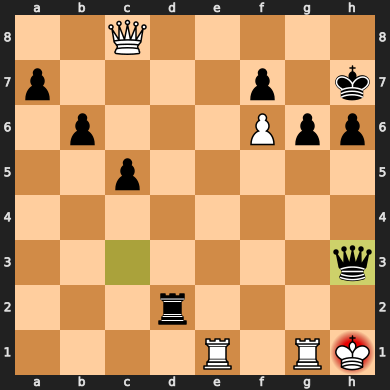

1.e4 e5 2.Bd3 Nc6 3.Nf3 Nf6 4.O-O Bc5 5.Bc4 O-O 6.Ng5 d5 7.exd5 Nxd5 8.Qh5 h6 9.Bd3 Qxg5 10.Qxg5 hxg5 11.Re1 f5 12.Re3 e4 13.Bc4 Be6 14.Rh3 b5 15.Be2 Nf4 16.Bh5 Nxh3+ 17.gxh3 g6 18.Bxg6 Rf6 19.Bh5 Rh6 20.Be2 Rxh3 21.d4 Nxd4 22.Bd1 f4 23.Nd2 Bf5 24.c3 e3 25.fxe3 fxe3 26.cxd4 exd2 27.Bxd2 Bxd4+ 28.Kf1 Rf8 29.Bb3+ Kg7 30.Ke1 Rxh2 31.Bb4 Re8+ 32.Kd1 Bg4+ 33.Kc1 Be3+ 34.Kb1 Bf5+ 35.Bc2 Rh1+
#


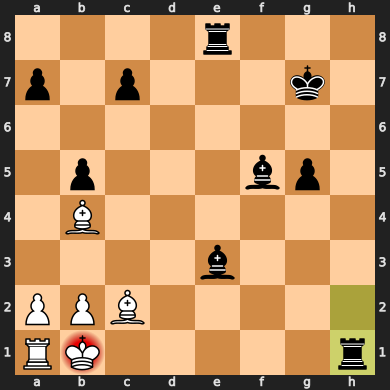

In [ ]:
count = 0
for key, value in next_token_predictions.items():
    if itos[value] == '#':
        transcript = (sub_data.loc[key].transcript)
        transcript_ending_in_check = get_transcript_ending_in_check(transcript)
        board = chess_utils.pgn_string_to_board(transcript_ending_in_check)
        print(transcript_ending_in_check)
        print(itos[value])
        display(board)
        count+=1
    if count > 3:
        break


In [ ]:
sub_data.loc[key].transcript

'1.e4 e5 2.Nc3 Nc6 3.Bc4 Bc5 4.d3 Nf6 5.f4 d6 6.Nf3 Be6 7.Bxe6 fxe6 8.Bd2 Ng4 9.Qe2 Bf2+ 10.Kf1 exf4 11.Bxf4 O-O 12.Bg5 Qe8 13.h3 Nd4 14.Qd1 Nxf3 15.gxf3 Qh5 16.Be7 Ne3+ 17.Kxf2 Nxd1+ 18.Raxd1 Rxf3+ 19.Ke2 Rf7+'

In [ ]:
encoded_with_feature = encoded[has_feature]
encoded_without_feature = encoded[~has_feature]

average_firing = encoded_with_feature.mean(dim=0)
average_non_firing = encoded_without_feature.mean(dim=0)
std_firing = encoded_with_feature.std(dim=0)
std_non_firing = encoded_without_feature.std(dim=0)
diff_average = average_firing-average_non_firing
diff_std = (std_firing ** 2 + std_non_firing ** 2) ** 0.5
diff_average/diff_std

tensor([0.0589, 0.3907, 0.3495,  ..., 0.0276, 0.0027, 0.0553], device='cuda:0',
       grad_fn=<DivBackward0>)

(array([   4.,    5.,   28.,   88.,  249.,  739., 1124.,  818.,  734.,
         241.]),
 array([-35.3522377 , -29.68709373, -24.02195168, -18.35680771,
        -12.69166374,  -7.02652073,  -1.36137736,   4.30376625,
          9.96890926,  15.63405323,  21.29919624]),
 <BarContainer object of 10 artists>)

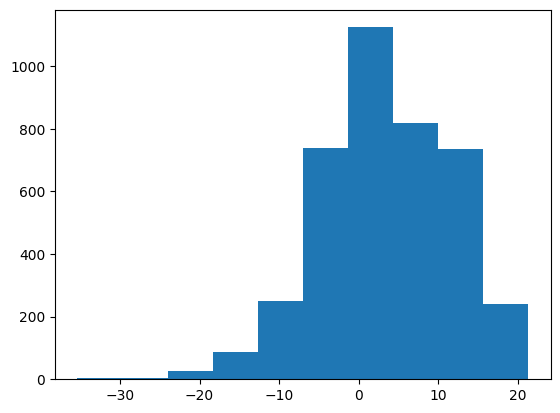

In [ ]:
import matplotlib.pyplot as plt

plt.hist((diff_average/diff_std).detach().cpu().numpy())

In [ ]:
highest_value_features = t.topk(diff_average, 30).indices
highest_value_features

tensor([2959, 1482, 1789, 3525,  471,  334, 2135, 3878, 2047,  837, 3223, 3289,
        3767, 2345, 2717, 1691, 2297, 3682, 1330, 2647,  756,  344,  766,   82,
        2627, 3947, 1579, 3330,  514, 3656], device='cuda:0')

In [ ]:
interesting_feature = highest_value_features[1]
indices_that_activate_this_feature = t.topk(encoded[:, interesting_feature], 5).indices
for index in indices_that_activate_this_feature:
    print(encoded[index, interesting_feature])
    #display(chess_utils.pgn_string_to_board(transcripts_list[index]))

NameError: name 'highest_value_features' is not defined

In [ ]:
sub_data = data_df[:10]
tokenized_games = []
has_feature = []
transcripts_list = []
feature = chess_utils.board_to_check_state
max_length = 512
for i, row in sub_data.iterrows():
    transcript = row.transcript
    sub_transcripts = cut_game_transcript(transcript, step_size = 1)
    for sub_transcript in sub_transcripts:
        board = chess_utils.pgn_string_to_board(sub_transcript)
        transcripts_list.append(sub_transcript)
        has_feature.append(bool(feature(board).item()))
        tokenized = t.tensor([stoi[c] for c in sub_transcript]).to(device)
        tokenized_games.append(F.pad(tokenized, (max_length - tokenized.shape[0], 0), mode='constant'))
normalized_diff_average = diff_average/diff_average.norm()
encoded = gated_sae.encode(t.stack(tokenized_games, dim=0))
similarity_matrix = encoded @ normalized_diff_average 


NameError: name 'diff_average' is not defined

In [ ]:
encoded

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.5795,  0.4063,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.7157,  0.0000],
        [ 0.0000,  7.9139,  0.0000,  ...,  0.0000,  0.2148,  0.0000],
        ...,
        [ 0.1216, 31.2001, 16.5472,  ...,  0.0000,  6.7901,  0.0000],
        [ 0.0000, 42.0829,  2.1518,  ...,  3.5874,  7.7130,  0.0000],
        [ 0.0000, 26.9511, 10.3768,  ...,  2.6747, 10.8060,  0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Example data
accuracies = []
indices_to_keep = has_feature.cpu() | (np.random.rand(len(has_feature)) < 0.05)
indices_to_keep = indices_to_keep.type(t.bool)

for i in highest_value_features:
    X = encoded[indices_to_keep, i].cpu().detach().numpy().reshape(-1, 1)  # Features
    y = has_feature[indices_to_keep].cpu()

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Initialize and train the classifier
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    accuracies.append(accuracy)

print(accuracies)


0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
0.6232876712328768
[0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876712328768, 0.6232876

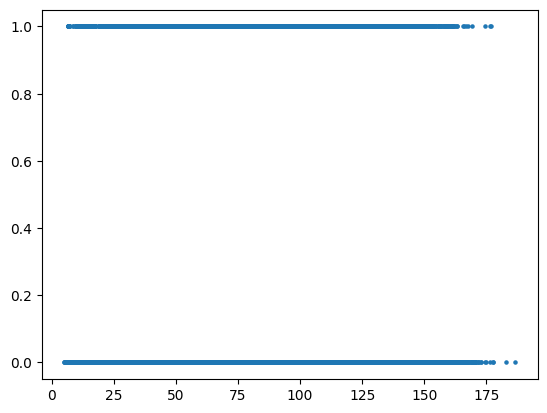

In [ ]:
plt.scatter(encoded[:, highest_value_features[1]].detach().cpu().numpy(), has_feature.detach().cpu().numpy(), s=5)

In [ ]:
encoded[:, highest_value_features[0]].sum()

tensor(2070953.7500, device='cuda:0', grad_fn=<SumBackward0>)

tensor(44.8334, device='cuda:0', grad_fn=<SelectBackward0>)


(array([1.53547859e-02, 1.06945632e-02, 5.61032602e-03, 4.36576963e-03,
        3.89595068e-03, 3.41042911e-03, 2.59642800e-03, 1.23278072e-03,
        2.90527730e-04, 4.71126048e-05]),
 array([  0.        ,  21.05321884,  42.10643768,  63.15966034,
         84.21287537, 105.26609802, 126.31932068, 147.37254333,
        168.42575073, 189.47897339, 210.53219604]),
 <BarContainer object of 10 artists>)

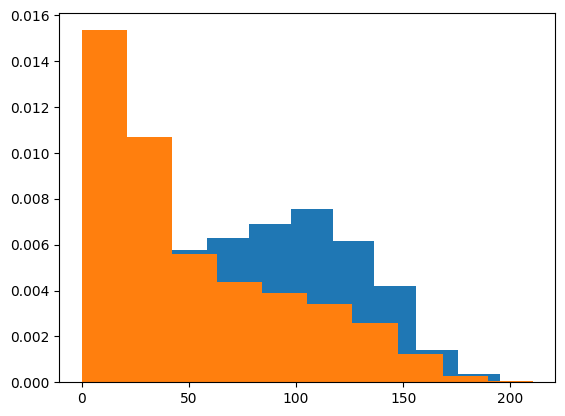

In [ ]:
print(std_firing[highest_value_features[0]])

plt.hist(encoded[has_feature, highest_value_features[0]].detach().cpu().numpy(), density=True)
plt.hist(encoded[~has_feature, highest_value_features[0]].detach().cpu().numpy(), density=True)
